# **Naive Bayes for Email Spam Detection**

### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
import email
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
wnl = WordNetLemmatizer()

### **Getting the data**

In [2]:
enron_df = pd.read_csv('emails.csv', encoding = 'utf-8')

In [3]:
enron_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [7]:
# Analyzing the representation of text in a message
enron_df.loc[0]['message']

"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "

In [8]:
# Extracting the body of all ham messages
mssgs = enron_df['message'].apply(email.message_from_string)
enron_df['body'] = mssgs.apply(lambda x: x.get_payload())

In [9]:
# Function to read from a file
def read_from_file(filename):
    with open(filename, 'r', encoding = "latin1") as f:
        return f.read()

In [10]:
# Getting the emails and saving it to a dataframe
fraud_data = read_from_file('fradulent_emails.txt')
fraud_data = fraud_data.split('From r')
fraud_df = pd.DataFrame(fraud_data, columns = ['message'], dtype = str)

In [11]:
# Extracting the body of all fradulent messages
mssgs = fraud_df['message'].apply(email.message_from_string)
fraud_df['body'] = mssgs.apply(lambda x: x.get_payload())

In [12]:
# Removing null values and empty strings
fraud_df = fraud_df[fraud_df['body'].notna()]
fraud_df = fraud_df[fraud_df['body'] != '']
# Getting indices of rows that are not a string
idx = fraud_df[fraud_df['body'].apply(lambda x: type(x) != str)].index
# Dropping these rows
fraud_df.drop(idx, inplace = True)

In [13]:
# Dropping all columns except message itself
enron_df.drop(['file', 'message'], axis = 1, inplace = True)
fraud_df.drop(['message'], axis = 1, inplace = True)

In [14]:
# Adding category columns to both dataframes
enron_df['category'] = 0
fraud_df['category'] = 1
# Combining both datasets and sampling each of them to 2000 random rows
emails_df = pd.concat([enron_df.sample(2000), fraud_df.sample(2000)], ignore_index = True)

### **Cleaning the data**

In [5]:
# Edit accordingly but takes a while to run
pos_tags = ["ADJ", "NOUN", "VERB"]
def lemmatize_with_tag(text, pos_tags = pos_tags):
    nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
    tagged_text = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ in pos_tags:
            tagged_text.append(token.lemma_)
        else:
            tagged_text.append(token.text)
    return(' '.join(tagged_text))

In [6]:
# Preprocessing the text
def clean_text(text, reg):
    text = text.lower()
    text = re.sub(reg, ' ', text)
    text = text.split()
    text = [wnl.lemmatize(word) for word in text if len(word) > 3 and word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [15]:
# Cleaning the text with regex, lemmatization without POS tags and removing stopwords
emails_df['body'] = emails_df['body'].apply(lambda x: clean_text(x, '[^a-z]'))
# Lemmatization with POS tags take a while, comment if needed
emails_df['body'] = emails_df['body'].apply(lambda x: lemmatize_with_tag(x))

In [16]:
emails_df.tail()

,body,category
3995,willams terry commercial bank senegal dial yor...,1
3996,audit accounting unit foreign operation depart...,1
3997,office revd peter clark director special duty ...,1
3998,html benedict hill national westminster bank n...,1
3999,dear madam name retire work next year write in...,1


### **Exploratory Data Analysis (EDA)**

**Analyzing if there's any correlation between length of the message and it's respective category**

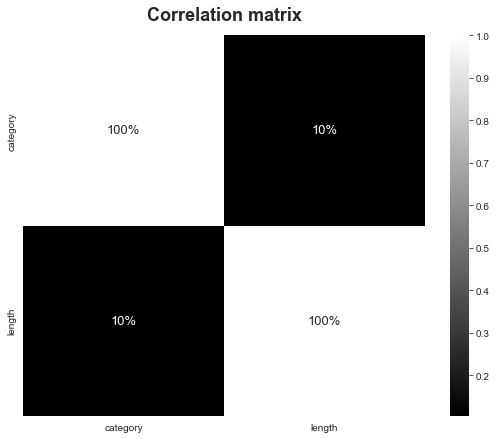

In [48]:
# Plotting correlation matrix for length of message and category
temp_df = emails_df
temp_df['length'] = temp_df['body'].apply(lambda x: len(x))
plt.figure(figsize = (9, 7))
plt.title('Correlation matrix', fontsize = 18, fontweight = 'bold', pad = 15)
# plot correlation matrix in percentage
sns.heatmap(temp_df.corr(), annot = True, fmt = '.0%', cmap = 'gray', annot_kws = {"size": 13})
plt.show()
# No correlation

**Let's find out if the top words of both categories have overlapping words**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
# Get top n words for any corpus
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

In [20]:
# Function to make top n words for a given feature and target
def make_top_n_words(df, text_col, target_col, n = None):
    list_of_targets = df[target_col].unique().tolist()
    indices = [df[df[target_col] == cat].index.values.tolist() for cat in list_of_targets]
    corpus = [df.loc[index][text_col].tolist() for index in indices]
    top_n_words = [get_top_n_words(text, n) for text in corpus]
    return top_n_words

In [21]:
top_20_w_per_cat = make_top_n_words(emails_df, 'body', 'category', 20)

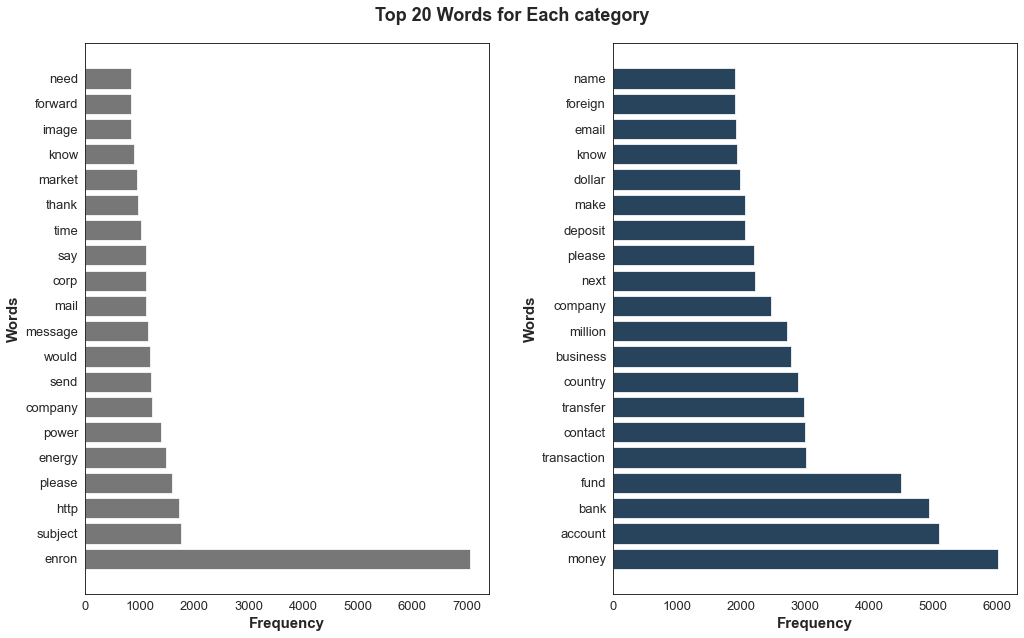

In [78]:
# Plotting the top 20 words for each category
plt.figure(figsize = (15, 18))
colors = ['#777777', '#27445C']
plt.suptitle('Top 20 Words for Each category', fontsize = 18, fontweight = 'bold', y = 0.96)
for i in range(len(top_20_w_per_cat)):
    plt.subplot(2, 2, i + 1)
    x, y = zip(*top_20_w_per_cat[i])
    plt.barh(x, y, color = colors[i], edgecolor = "#fff", linewidth = 0.75, height = 0.8, align = 'center')
    plt.xticks(fontsize = 13)
    plt.xlabel('Frequency', fontsize = 15, fontweight = 'bold')
    plt.yticks(fontsize = 13)
    plt.ylabel('Words', fontsize = 15, fontweight = 'bold')
    plt.tight_layout(pad = 3.5)

**Not a lot of common words but let's remove what we have**

In [23]:
# Find common words with top_20_w_per_cat
common_words = []
for i in range(len(top_20_w_per_cat[0])):
    if top_20_w_per_cat[0][i][0] in [word[0] for word in top_20_w_per_cat[1]]:
        common_words.append(top_20_w_per_cat[0][i][0])
common_words

['please', 'company', 'know']

In [24]:
common_words.append('enron')

In [25]:
# Removing words that are in common words for email_df
emails_df['body'] = emails_df['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in common_words]))

### **Convert the text data into vectors**

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
# Function that returns tf-idf matrix and vector
def make_tfidf_vectorizer(data, ng = (1,1)):
    vectorizer = TfidfVectorizer(ngram_range = ng)
    matrix = vectorizer.fit_transform(data)
    return matrix, vectorizer

In [28]:
# Getting tf-idf matrix and vector for the body column
tfidf_matrix, tfidf_vectorizer = make_tfidf_vectorizer(emails_df['body'])

### **Splitting the data into train and test sets**

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB

In [30]:
# Creating a set of models and their parameters
model_params = {
    'bernoulli_nb' : 
    {
        'model' : BernoulliNB(),
        'params' : 
        {
            'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1],
            'binarize' : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'fit_prior' : [True, False]
        }
    },
    'multinomial_nb' : 
    {
        'model' : MultinomialNB(),
        'params' : 
        {
            'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1],
            'fit_prior' : [True, False],
            'class_prior' : [None, [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]]        
        }
    },
    'gaussian_nb' : 
    {
        'model' : GaussianNB(),
        'params' : 
        {
            'var_smoothing' : np.logspace(0, -9, num = 100)
        }
    }
}

In [31]:
# Using the best parameters to train each model
x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix.toarray(), emails_df['category'], test_size = 0.2)

In [32]:
# To store model scores
model_scores = []
y_predictions = []
# y_predictions_proba = [] # Uncomment if needed
# Looping through the models and their parameters
for modelName, mp in model_params.items():
    # Doing a grid search to find the best parameters using 10 fold cross validation
    clf = GridSearchCV(mp['model'], mp['params'], cv = 10, return_train_score = False)
    clf.fit(x_train, y_train)
    y_predictions.append(clf.predict(x_test))
    # y_predictions_proba.append(clf.predict_proba(x_test)) # Uncomment if needed
    # Storing the best model, thier parameters and best score
    model_scores.append({
        'model' : modelName,
        'best_params' : clf.best_params_,
        'best_score' : clf.best_score_
    })

In [33]:
# Converting above list of dictionaries to a dataframe
scores_df = pd.DataFrame(model_scores, columns = ['model', 'best_params', 'best_score'])
scores_df

,model,best_params,best_score
0,bernoulli_nb,"{'alpha': 1e-05, 'binarize': 0.0, 'fit_prior':...",0.988750
1,multinomial_nb,"{'alpha': 0.1, 'class_prior': [0.7, 0.3], 'fit...",0.992500
2,gaussian_nb,{'var_smoothing': 0.008111308307896872},0.984062


### **Evaluating the model**

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [35]:
# Function to plot roc curve
def plot_roc_auc_curve(predictions, y_test, model_names, colors):
    plt.figure(figsize = (9, 7))
    plt.rcParams['axes.edgecolor'] = '#000'
    for i in range(len(predictions)):
        fpr, tpr, _ = roc_curve(y_test, predictions[i])
        auc = round(roc_auc_score(y_test, predictions[i]), 3)
        plt.plot(fpr, tpr, label = model_names[i] + ', AUC = ' + str(auc), linewidth = 2.5, color = colors[i], alpha = 0.8)
        plt.xlabel('False Positive Rate', fontsize = 13)
        plt.ylabel('True Positive Rate', fontsize = 13)
        plt.title('ROC Curve', fontsize = 16, fontweight = 'bold')
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.legend(labelcolor = '#fff', loc = 'lower right', fontsize = 12, facecolor = '#444', edgecolor = '#444', framealpha = 0.5, fancybox = True, shadow = True, borderpad = 2,)
        plt.tight_layout(pad = 3)

In [36]:
# Function for getting all the scores
def get_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, auc, precision, recall, f1

In [74]:
# Function for plotting all the metrics for all the models
def plot_metrics(metrics_list, title, x_ticks, no_of_ticks = 2, y_lim = (0, 1)):
    df_metrics = pd.DataFrame(metrics_list, columns = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
    sns.set_palette('mako')
    df_metrics.plot(kind = 'bar', figsize = (22, 12))
    for p in plt.gca().patches:
        # annotate bars with their percentage value
        plt.gca().annotate('{:.2%}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', fontsize = 11, color = '#000', xytext = (0, 10), textcoords = 'offset points', fontweight = 'bold')
    plt.title(title, fontsize = 16, fontweight = 'bold', pad = 15)
    plt.xticks(np.arange(no_of_ticks), x_ticks, rotation = 0)
    plt.ylim(y_lim)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 11)
    plt.legend(labelcolor = '#fff', loc = 'lower right', fontsize = 12, facecolor = '#000', edgecolor = '#fff', framealpha = 0.9, fancybox = True, shadow = True, borderpad = 2)
    plt.show()

In [38]:
# Function to get classification report for each model
def get_classification_report(y_test, y_pred):
    return pd.DataFrame(classification_report(y_test, y_pred, target_names = ['Not Spam', 'Spam'], output_dict = True)).transpose()

In [39]:
cr_list = []
for pred in y_predictions:
    cr_list.append(get_classification_report(y_test, pred))

In [40]:
cr_list[0]

,precision,recall,f1-score,support
Not Spam,0.985112,1.000000,0.9925,397.0000
Spam,1.000000,0.985112,0.9925,403.0000
accuracy,0.992500,0.992500,0.9925,0.9925
macro avg,0.992556,0.992556,0.9925,800.0000
weighted avg,0.992612,0.992500,0.9925,800.0000


In [41]:
cr_list[1]

,precision,recall,f1-score,support
Not Spam,0.992500,1.000000,0.996236,397.00000
Spam,1.000000,0.992556,0.996264,403.00000
accuracy,0.996250,0.996250,0.996250,0.99625
macro avg,0.996250,0.996278,0.996250,800.00000
weighted avg,0.996278,0.996250,0.996250,800.00000


In [42]:
cr_list[2]

,precision,recall,f1-score,support
Not Spam,0.989691,0.967254,0.978344,397.00000
Spam,0.968447,0.990074,0.979141,403.00000
accuracy,0.978750,0.978750,0.978750,0.97875
macro avg,0.979069,0.978664,0.978743,800.00000
weighted avg,0.978989,0.978750,0.978746,800.00000


In [43]:
sns.set_style('white')

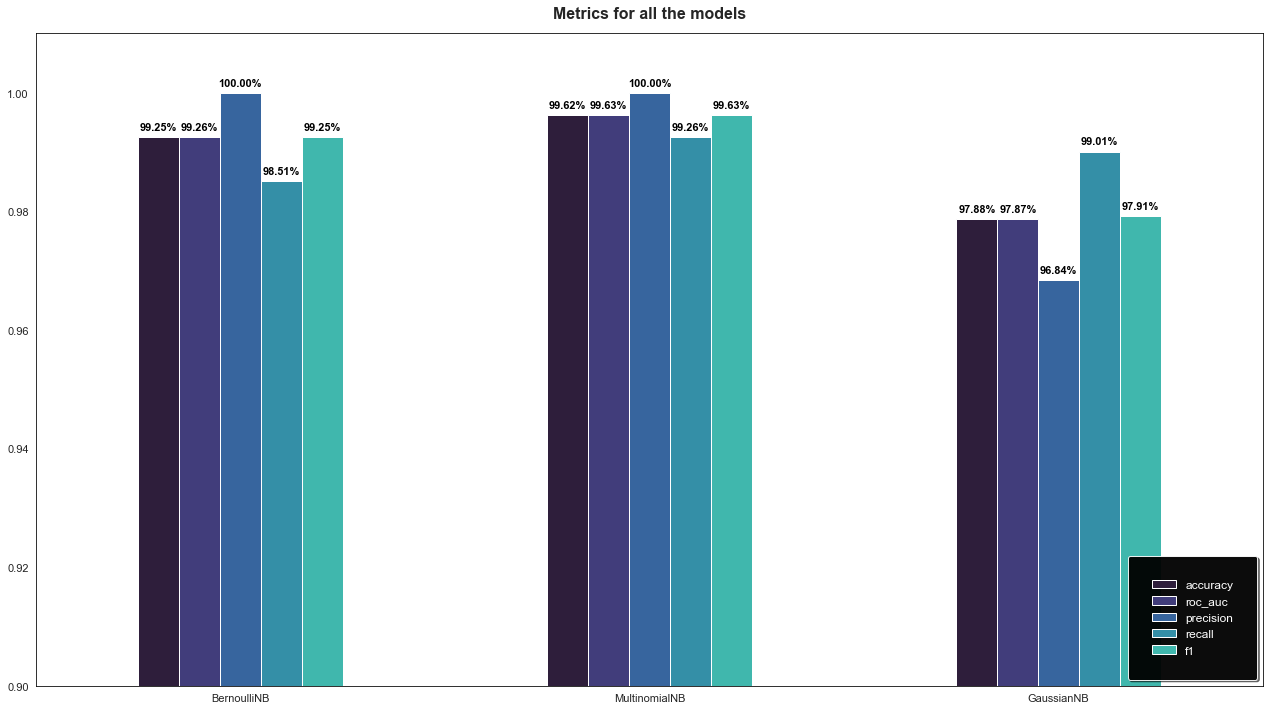

In [75]:
# Getting metrics for each model
metrics_list = []
model_names = ['BernoulliNB', 'MultinomialNB', 'GaussianNB']
for pred in y_predictions:
    metrics_list.append(get_metrics(y_test, pred))
# Plotting metrics for each model
# Second last parameter is the number of classifiers on x-axis, last parameter is the y-axis limit (default is (0, 1))
plot_metrics(metrics_list, 'Metrics for all the models', model_names, 3, (0.9, 1.01))

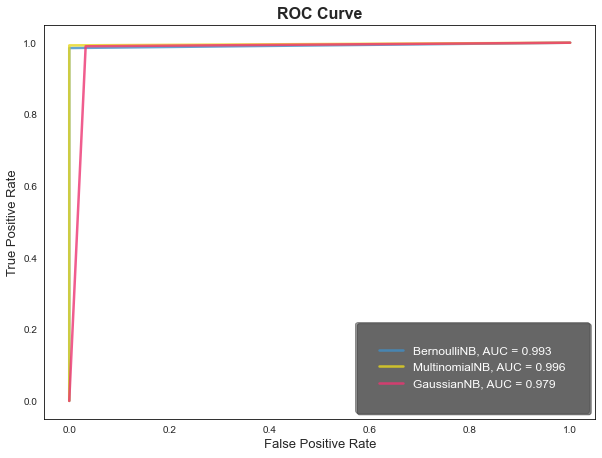

In [45]:
plot_roc_auc_curve(y_predictions, y_test, model_names, ['#408ec6', '#e8d71e', '#ed3572'])

In [46]:
# Plotting confusion matrix for all models
def plot_confusion_matrix(y_test, y_pred, title, act_cols, pred_cols):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index = act_cols, columns = pred_cols)
    plt.figure(figsize = (10, 8))
    plt.title(title, fontsize = 14, fontweight = 'bold', pad = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.tight_layout(pad = 5)
    sns.heatmap(cm_df / np.sum(cm), annot = True, cmap = 'gray', fmt = '.2%', annot_kws = {'size' : 11.5}, linewidths = 1, linecolor = '#000', square = True)

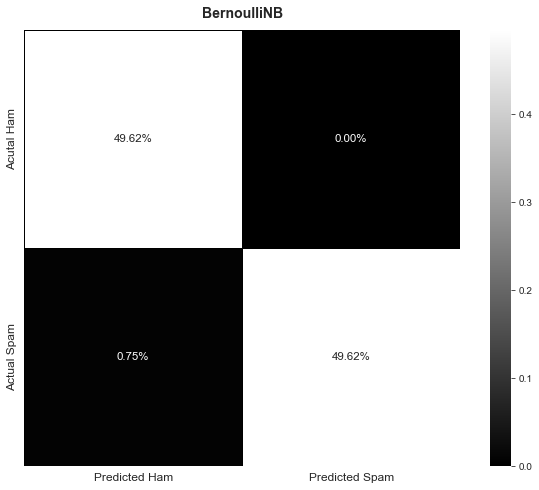

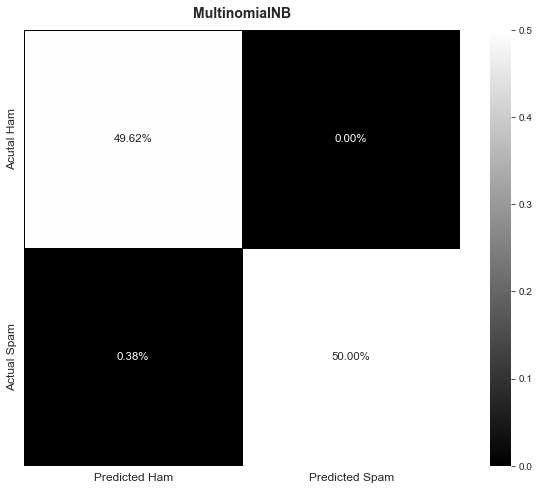

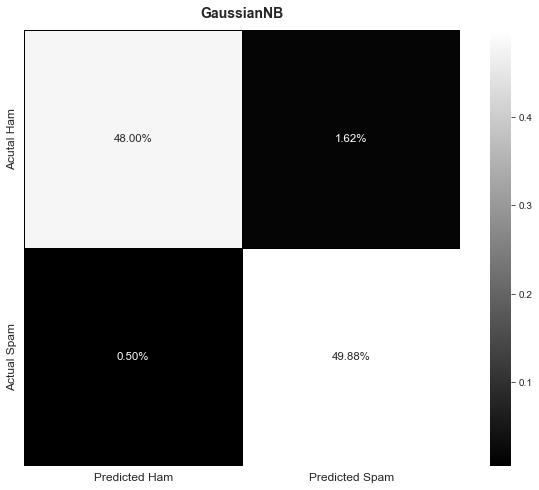

In [47]:
# Plotting confusion matrix for all models
for i in range(len(y_predictions)):
    plot_confusion_matrix(y_test, y_predictions[i], model_names[i], ['Acutal Ham', 'Actual Spam'], ['Predicted Ham', 'Predicted Spam'])